In [1]:
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates

from IPython.display import display

import shapely
import shapely.geometry
from shapely.geometry import shape

import matplotlib.gridspec as gridspec
import numpy as np
from scipy import ndimage
from scipy.ndimage import measurements
from scipy import stats




In [2]:
dc = datacube.Datacube()


## User defined imput cell: 
use this cell to define the spatiotempral range of interest, also enter the site name and the file path location

In [3]:

###Define file name for where results should be saved###

file_location = 'Pictures/picsSPLIT/'

site_name = 'Mt_Mitchell_2012'

#Define temporal range
start_of_epoch = '1990-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2015-01-01'

#Define the year you wish to use as a reference point
ref_year = 2011
#Define the year you wish to use to detect change
change_year = 2013


#Define temporal range FOR RAINFALL (only a year around landslide time)
rain_start_of_epoch = '1994-01-01'
#need a variable here that defines a rolling 'latest observation'
rain_end_of_epoch =  '1996-01-01'


#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest
sensors = ['ls5','ls7','ls8'] 

##Define spacial range

query = {'time': (start_of_epoch, end_of_epoch)}
lat_max = -28.03
lat_min = -28.08
lon_max = 152.45
lon_min = 152.33  
  
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG: 4326'

In [4]:
#EPSG:4326

In [5]:
#Load rainfall data
#lat-long automatically carried across from previous query

rain_data = dc.load(product='bom_rainfall_grids', x=(lon_max, lon_min), y=(lat_max, lat_min), time=(rain_start_of_epoch, rain_end_of_epoch))

In [6]:
#Move rain data about into a from that can be plotted

time_ind = rain_data['time'].to_index()
rain2 = rain_data.isel(latitude=0, longitude=0)
rain3 = rain2.to_array()
rain4 = rain3[0,:]

In [7]:
# load evevation data DEM
# resolution is set to 25m sq like lst data
#lat-long automatically carried across from previous query

dem_data = dc.load(product='srtm_dem1sv1_0', x=(lon_max, lon_min), y= (lat_max, lat_min),
                   output_crs='EPSG:3577', resolution=(-25,25))

dem_dataset1 = dem_data.dem_h

#remove excess peramiters from data so that we just have the array of elevation data
dem_dataset2 = dem_dataset1[0,:,:]

In [8]:
# All of this reads the size of the data arrays as sets a scale 
#for plotting suited to the size of the data

ploty,plotx = (dem_dataset2.shape)
if ploty <= 80:
    ploty = ploty/6
    plotx = plotx/6
    
elif ploty <= 200:
    ploty = ploty/10
    plotx = plotx/10
    
elif ploty < 400:
    ploty = ploty/20
    plotx = plotx/20
    
elif ploty < 500:
    ploty = ploty/26
    plotx = plotx/26
    
elif ploty < 800:
    ploty = ploty/35
    plotx = plotx/35   
elif ploty > 800:
    ploty = ploty/80
    plotx = plotx/80
  

    
if ploty > 20:
    ploty = ploty/2
    plotx = plotx/2
    


In [9]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensors[0]+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [10]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [11]:

#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor_nbar
    if sensor_nbar:
        sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
        #grab the projection info before masking/sorting
        crs = sensor_nbar.crs
        crswkt = sensor_nbar.crs.wkt
        affine = sensor_nbar.affine
        #This line is to make sure there's PQ to go with the NBAR
        sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
        #Apply the PQ masks to the NBAR
        cloud_free = masking.make_mask(sensor_pq, **mask_components)
        good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
        sensor_nbar = sensor_nbar.where(good_data)
        sensor_clean[sensor] = sensor_nbar
        print(sensor_nbar.crs)
        print(sensor_nbar)

EPSG:3577
<xarray.Dataset>
Dimensions:  (time: 623, x: 496, y: 297)
Coordinates:
  * time     (time) datetime64[ns] 1990-02-14T23:09:47.500000 ...
  * y        (y) float64 -3.199e+06 -3.199e+06 -3.199e+06 -3.199e+06 ...
  * x        (x) float64 1.966e+06 1.966e+06 1.966e+06 1.966e+06 1.966e+06 ...
Data variables:
    blue     (time, y, x) float64 253.0 290.0 326.0 308.0 272.0 290.0 344.0 ...
    green    (time, y, x) float64 499.0 537.0 575.0 500.0 462.0 462.0 538.0 ...
    red      (time, y, x) float64 485.0 553.0 553.0 485.0 451.0 451.0 553.0 ...
    nir      (time, y, x) float64 2.679e+03 2.809e+03 2.766e+03 2.418e+03 ...
    swir1    (time, y, x) float64 1.446e+03 1.567e+03 1.628e+03 1.385e+03 ...
Attributes:
    crs:      EPSG:3577
EPSG:3577
<xarray.Dataset>
Dimensions:  (time: 579, x: 496, y: 297)
Coordinates:
  * time     (time) datetime64[ns] 1999-07-09T23:41:04.500000 ...
  * y        (y) float64 -3.199e+06 -3.199e+06 -3.199e+06 -3.199e+06 ...
  * x        (x) float64 1.966e+0

In [12]:
nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

In [13]:
#calculate NDWI

ndwi = ((nbar_clean.nir-nbar_clean.swir1)/(nbar_clean.nir+nbar_clean.swir1))

In [14]:
#Calculate annual average NDWI values
annual_ndwi = ndwi.groupby('time.year')
annual_mean_ndwi = annual_ndwi.mean(dim = 'time') 

In [15]:

#Calculate the difference between in mean NDWI between two years, a reference year and a change year

nd_ref_year = annual_mean_ndwi.sel(year = (ref_year))
nd_change_year =annual_mean_ndwi.sel(year = (change_year))
nd_dif = nd_change_year - nd_ref_year



In [16]:
#set the detection limmit. here we are looking for a difference greater that 0.2 in NDWI between reference and change year
nd_dif_filt = nd_change_year.where(abs(nd_dif)>0.14) #abs makes it absolute numbers (neg or ps)



In [17]:
nd_dif_rev = nd_dif * -1 #make positive numers negaitive and negative numbers positive, 
#becasue we are actually looking for a DECREASE in NDWI no an INCREASE
nd_dif_filt_rev = nd_change_year.where((nd_dif_rev)>0.2) #abs makes it absolute numbers (neg or ps)



In [18]:
#Now that the NDWI stuff is done let's add slope
#convert the elevation data to gradient using g=rize over run
datagrad2,datagrad3 = np.gradient(dem_dataset2, axis=(0,1))

#convert to degrees slope using slope = tan-1(rize/run) and gradient = rise/run. 
#therefore slope = tan-1(gradient)
dataslope_ns = np.rad2deg(np.arctan(datagrad2))
dataslope_ew = np.rad2deg(np.arctan(datagrad3))

#turn angle of slope into absolute values
dataslope_ns_abs = np.absolute(dataslope_ns)
dataslope_ew_abs = np.absolute(dataslope_ew)

#combine NS and EW slopemaps into a sigle map, with largest values for each square
dataslope_all = np.maximum(dataslope_ns_abs, dataslope_ew_abs)


In [19]:
#apply a Gaussian filter to smooth image, to remove data artifacts, sigma 1.5. 
#This does loose some fine detail but is fine for our purpose
gsm_dataslope_all = ndimage.gaussian_filter(dataslope_all, sigma=1.5)



In [20]:
# Now plot the map of NDWI filtered to 0.17 to only how areas with a slope greater that 15degrees

ndvi_steep_slope = nd_dif_filt_rev.where(gsm_dataslope_all>15)



In [21]:
#calculate visible light (red band) change

red = (nbar_clean.red)

#Calculate annual average visible light values
annual_red = red.groupby('time.year')
annual_mean_red = annual_red.mean(dim = 'time') 

#calculate the differece between two years, referece year and change year
red_ref_year = annual_mean_red.sel(year = (ref_year))
red_change_year =annual_mean_red.sel(year = (change_year))
red_dif = ((red_change_year - red_ref_year)/red_ref_year)

red_dif_limit = red_dif.where(red_dif>0.5)

red_dif_steep = red_dif_limit.where(gsm_dataslope_all>15)



In [22]:
#now filter the data to only show where all three factors occur; change in NDWI > 0.2 + slope of more that 15%
#and redlight increases by more that 0.4.

red_and_NDWI_steep= ndvi_steep_slope.where((red_dif) > 0.5)



In [23]:


#create functions to generate clusters, and list of cluster centers in order of size, correct orinetation for plotting
def create_clusters(imput_array, cluster_size):
    
    def moreThanFour(element):
        return element > cluster_size
    
    name_positive = imput_array > 0 #create boolian array where only data exists for input array
    
    name_lbd_clusters, name_num = measurements.label(name_positive) #creates clusters in data, labled top to bottom
    
    #determine the area of the clusters, by counting the number of squares they contain.
    name_area = measurements.sum(name_positive, name_lbd_clusters, index=np.arange(name_lbd_clusters.max() +1))
    #create a list of these clusters that are larger that four squares together
    name_point_list=filter(moreThanFour, name_area)
    
    
    #now make an array with the lables according to area.
    output_array = name_area[name_lbd_clusters]
    
    # create a list of tuples, containing the coords of the center of the clusters larger than 4 squares
    name_lst_cent = measurements.center_of_mass(name_positive, output_array, name_point_list)
    #swap values in tuples so that X,Y coord are in correct order for plotting
    output_list = [(b,a) for a,b in name_lst_cent]
    return output_list, output_array
#end Function definition

In [24]:
good_all_lst_cent, array_all_clus = create_clusters(red_and_NDWI_steep, 4)

red_lst_cent, array_red_clus = create_clusters(red_dif_steep, 4)

ndwi_lst_cent, array_ndwi_clus = create_clusters(ndvi_steep_slope, 4)


/g/data/v10/public/modules/agdc-py2-env/20170426/envs/agdc/lib/python2.7/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


In [34]:
spesh_date = '2012-5-25'

In [35]:
rgb = nbar_clean.sel(time =spesh_date, method = 'nearest').to_array(dim='color').sel(color=['red', 'green', 'blue'])
array_dmentions = rgb.shape

In [36]:
rgb

<xarray.DataArray (color: 3, time: 1, y: 297, x: 496)>
array([[[[  nan, ...,   nan],
         ..., 
         [ 430., ...,  664.]]],


       ..., 
       [[[  nan, ...,   nan],
         ..., 
         [  10., ...,  241.]]]])
Coordinates:
  * y        (y) float64 -3.199e+06 -3.199e+06 -3.199e+06 -3.199e+06 ...
  * x        (x) float64 1.966e+06 1.966e+06 1.966e+06 1.966e+06 1.966e+06 ...
  * color    (color) <U5 u'red' u'green' u'blue'
  * time     (time) datetime64[ns] 2012-05-25T23:42:51.500000
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 1965575.00|\n| 0.00,-25.00,-3199150.00|\n| 0.00,...

In [37]:
#create true colour satellite image
special_indicator = False

#This code now looks at the shape of rgb, to see if it will plot correctly.
#if it won't, it is reshaped to have the correct shape 
list_of_dims = []

for x in array_dmentions:
    list_of_dims.append(x)

if len(list_of_dims) == 3:
    
    rgb = rgb.transpose('y', 'x', 'color')
else:
    rgb = rgb.transpose('y', 'x', 'color','time')

#if the code could not pull a valid satelite image (if time is equalt to 0 the there is no data) 
#it will try and find a new valid one

    

    try:
        rgb = rgb[:,:,:,0]
    except:
        try:
            while rgb.time.shape < 0:
                year_string = rain_end_of_epoch[:5]
                month_string = rain_end_of_epoch[5]
                month_int = int(month_string)
                month_int = month_int + 1
                if month_int > 12:
                    print('could not find valid pass, used NDWI change as background')
                    rgb = red_dif
                    special_indicator = True
                    break
                else:
                    month_string2 = str(month_int)
                    rain_end_of_epoch = year_string + month_string2
                    print rain_end_of_epoch
                    rgb = nbar_clean.sel(time =rain_end_of_epoch, method = 'nearest').to_array(dim='color').sel(color=['red', 'green', 'blue'])
            if special_indicator == False:
                rgb = rgb.transpose('y', 'x', 'color','time')
                rgb = rgb[:,:,:,0]
        except:
            special_indicator = True
            rgb = red_dif
            print('tryed really hard but could not find a valid satelite pass close to requested date')

In [38]:
fake_saturation = 1500
sat_pickie = rgb.where(rgb<fake_saturation).fillna(fake_saturation)/fake_saturation

/g/data/v10/public/modules/agdc-py2-env/20170426/envs/agdc/lib/python2.7/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


In [39]:

if special_indicator == False:
    title_string = str(rgb.time)
else:
    title_string = 'change in NDWI used as background image'


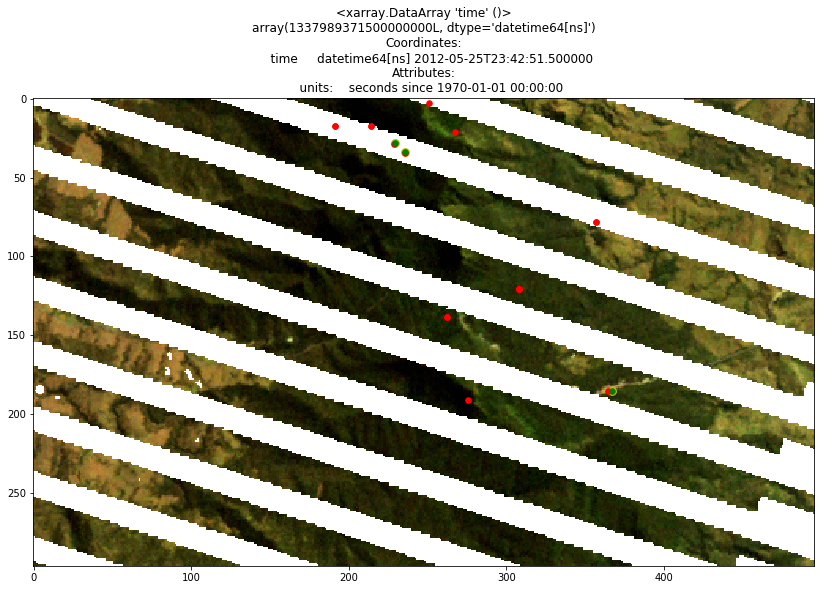

In [40]:
#plot the colour satelighte image with points of potential landslides on it
fig, ax = plt.subplots(figsize=(ploty,plotx))
plt.title(title_string)
ax.imshow(sat_pickie, cmap='coolwarm', interpolation='nearest')

#add dots to plots
try:
    plt.scatter(*zip(*good_all_lst_cent),c='y', s=60)
    landslides_exist = True
except: 
    print('no potential landlside events detected')
    landslides_exist = False
try:
    plt.scatter(*zip(*red_lst_cent),c='r', s=30)
except:
    print('no significant changes in visible light refectance')
try:    
    plt.scatter(*zip(*ndwi_lst_cent),c='g', s=30)
except:
    print('no significant decrease in NDWI')

#plt.show()
plt.savefig(file_location+site_name+'MasterMap.png')
plt.show()
plt.close()
#plot rainfall around that time
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(time_ind, rain4)
plt.savefig(file_location+site_name+'rainfallreccord.png')
#plt.show()
plt.close()



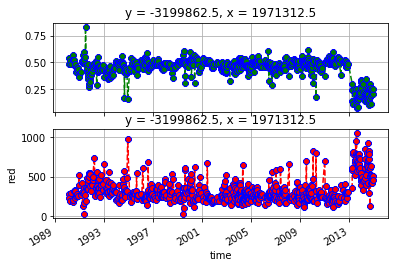

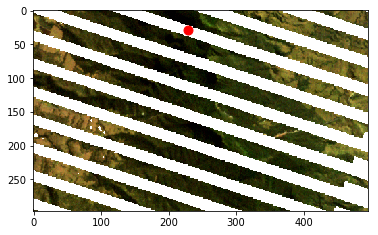

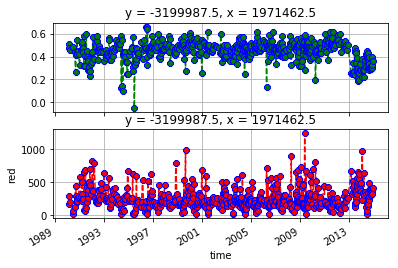

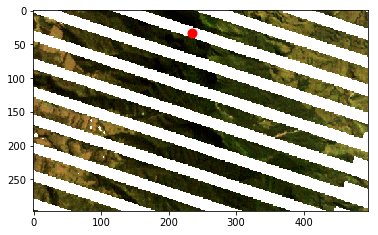

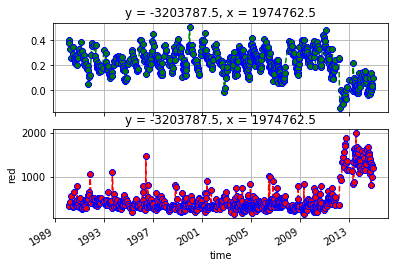

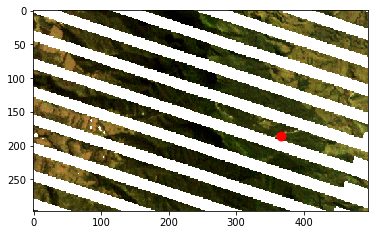

In [41]:
if landslides_exist == True:
    #Now plot a timeseries graph for changes in NDWI with the indicator plot for that position only 
    count = 0
    for x,y in good_all_lst_cent:
        if x > 0:
            #set up lat-long for ndwi/redlight rill to cycle through pot/landslide events lits
            tup_x = int(x)
            tup_y = int(y)
            #set up stuff for file output nameing
            x_string = str(tup_x)
            y_string = str(tup_y)
            count = count+1
            count_val = str(count)
            title_string = 'x= ' + x_string + ', y= '+ y_string

            #prepare ndwi7 vis light record for single point over epoc
            ts_ndwi = ndwi.isel(x=tup_x,y=tup_y)
            ts_ndwi = ts_ndwi.dropna('time', how = 'any')

            ts_red = red.isel(x=tup_x,y=tup_y)
            ts_red = ts_red.dropna('time', how = 'any')

            #prepare scatter plots       
            plt.figure(1)
            plt.subplot(211)
            ts_ndwi.plot(linestyle= '--', c= 'g', marker = '8', mec = 'b', mfc ='g')         
            plt.grid()

            plt.subplot(212)
            ts_red.plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')      
            plt.grid()
            #plt.show()
            #save plots to file
            plt.savefig(file_location+count_val+'plots'+title_string+'.png')
            plt.show()
            plt.close()

            plt.figure(2)
            fig, ax = plt.subplots(figsize=(6,6))
            ax.imshow(sat_pickie, cmap='coolwarm', interpolation='nearest')

    #add dots to plots
            plt.scatter(x=tup_x, y=tup_y, c='r', s=80)
            
            plt.savefig(file_location+'map'+count_val+' location'+title_string+'.png')
            plt.show()
            plt.close()
            

        

In [33]:
months=[1,2,3,4,5,6,7,8,9,10,11,12]
days = [5,10,15,20,25]

#try and find a valid satelite image for before the landslide
for month in months:
    for day in days:
        year_string = str(ref_year)+'-'
        time_use = year_string + str(month)+'-'+str(day)
        rgb = nbar_clean.sel(time =time_use, method = 'nearest').to_array(dim='color').sel(color=['red', 'green', 'blue'])

        array_dmentions =rgb.shape
        list_of_dims = []

        for x in array_dmentions:
            list_of_dims.append(x)

        if len(list_of_dims) == 4:
            rgb = rgb.transpose('y', 'x', 'color','time')
            date = rgb.time
            try:
                rgb = rgb[:,:,:,0]
            except:
                print('skip month')

        else:
            rgb = rgb.transpose('y', 'x', 'color')

        fake_saturation = 1500
        sat_pickie = rgb.where(rgb<fake_saturation).fillna(fake_saturation)/fake_saturation

        try:
            title_string = time_use
            count = 1
            fig, ax = plt.subplots(figsize=(15,15))
            plt.title(time_use)
            ax.imshow(sat_pickie, cmap='coolwarm', interpolation='nearest')
            plt.savefig(file_location+title_string+site_name+'png')
            plt.show()
            plt.close()
        except:
            print('month has been skiped'+time_use)

###try and find a valid satelite image for After the landslide
for month in months:
    for day in days:
        year_string = '2016'+'-'
        time_use = year_string + str(month)+'-'+str(day)
        rgb = nbar_clean.sel(time =time_use, method = 'nearest').to_array(dim='color').sel(color=['red', 'green', 'blue'])

        array_dmentions =rgb.shape
        list_of_dims = []

        for x in array_dmentions:
            list_of_dims.append(x)

        if len(list_of_dims) == 4:
            rgb = rgb.transpose('y', 'x', 'color','time')
            date = rgb.time
            try:
                rgb = rgb[:,:,:,0]
            except:
                print('skip month')

        else:
            rgb = rgb.transpose('y', 'x', 'color')

        fake_saturation = 1500
        sat_pickie = rgb.where(rgb<fake_saturation).fillna(fake_saturation)/fake_saturation

        try:
            title_string = time_use
            count = 1
            fig, ax = plt.subplots(figsize=(15,15))
            plt.title(time_use)
            ax.imshow(sat_pickie, cmap='coolwarm', interpolation='nearest')
            plt.savefig(file_location+title_string+site_name+'png')
            plt.show()
            plt.close()
        except:
            print('month has been skiped'+time_use)